<h1>BrainNetCNN Synthetic Experiments</h1>
<p>Version 1.0 <br />
Software by <a href='http://kawahara.ca/about/'>Jeremy Kawahara</a>, <a href='http://www.sfu.ca/~cjbrown/'>Colin J Brown</a>, and <a href='https://www.cs.sfu.ca/~hamarneh/'>Ghassan Hamarneh</a><br />
<a href='http://mial.sfu.ca/'>Medical Image Analysis Lab</a>, Simon Fraser University, Canada, 2017<br />
Implements method and synthetic experiments described in: <a href='dx.doi.org/10.1016/j.neuroimage.2016.09.046'>dx.doi.org/10.1016/j.neuroimage.2016.09.046</a><br />
</p>

<p>These results should closely match those in Table 2</p>

In [1]:
from __future__ import print_function
import os
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2
# If you don't have pycaffe in path.
# sys.path.insert(0, os.path.join('/home/jer/projects/caffe/', 'python')) 
import caffe
# To import ann4brains if not installed.
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..'))) 
from ann4brains.synthetic.injury import ConnectomeInjury
from ann4brains.nets import BrainNetCNN, load_model

<h1>Generate synthetic data</h1>

In [3]:
# Number of outputs.
n_injuries = 2 # NOTE: The synthetic code only works for 2 injuries right now.

n_samples = 100  # Number of training/testing samples.
noise_weight = 0.125  # How much to weigh the noise.

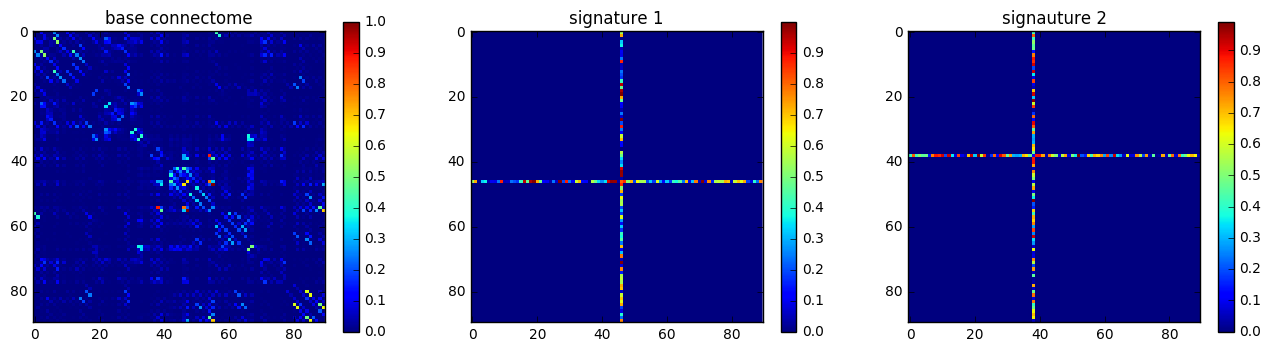

In [4]:
# Object to create synthetic injury data.
injury = ConnectomeInjury(base_filename=os.path.join('data', 'base.mat'), # Where the base matrix is.
                          n_injuries=n_injuries, # Only works for 2 injuries right now.
                          signature_seed=333, # Set the seed so we generate the same signatures.
                         ) 

# View the realistic base connectome and the injury signatures.
plt.figure(figsize=(16,4))
plt.subplot(1,3,1); plt.imshow(injury.X_mn, interpolation="None"); 
plt.colorbar(); plt.title('base connectome')
plt.subplot(1,3,2); plt.imshow(injury.sigs[0], interpolation="None"); 
plt.colorbar(); plt.title('signature 1')
plt.subplot(1,3,3); plt.imshow(injury.sigs[1], interpolation="None"); 
plt.colorbar(); plt.title('signauture 2')

In [5]:
# Generate train, validate, and test data
np.random.seed(seed=333) # To reproduce results.
x_train, y_train = injury.generate_injury(n_samples=112, noise_weight=0.125)
x_test, y_test = injury.generate_injury(n_samples=56, noise_weight=0.125)
x_valid, y_valid = injury.generate_injury(n_samples=56, noise_weight=0.125)

In [6]:
print(x_train.shape) # 112 samples of size 90 x 90 (1 since there's only 1 channel)
print(y_train.shape) # How much each of the 2 signatures weight the 112 samples.

(112, 1, 90, 90)
(112, 2)


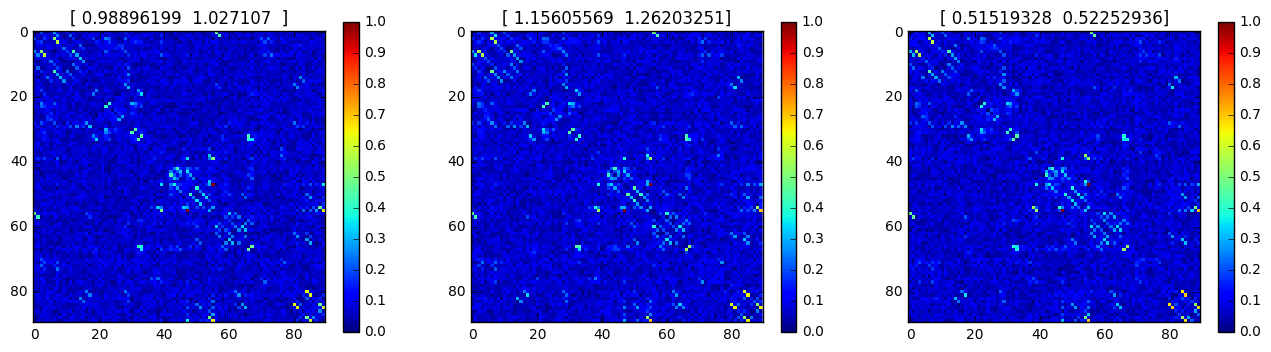

In [7]:
# Show example noisy training data that have the signatures applied.
# It's not obvious to the human eye the subtle differences, but the cross row and column above 
# perturbed the below matrices with the y weights.
plt.figure(figsize=(16,4))
for idx in range(3):
    plt.subplot(1,3,idx+1); plt.imshow(np.squeeze(x_train[idx]), interpolation="None"); 
    plt.colorbar();
    plt.title(y_train[idx]) # How much each signature is weighted by.

In [8]:
# Spatial height and width of the data. 
h = x_train.shape[2]
w = x_train.shape[3]
print(h, w)

90 90


<h1>Edge-to-Node test</h1>
<p>Example of using the Edge-to-Node (E2N) layer.</p>

In [9]:
# Unique name for the model
net_name = 'E2Nnet_sml'

# Specify the architecture using a list of dictionaries.
e2n_arch = [
    ['e2n', # e2n layer 
     {'n_filters': 130, # 130 feature maps 
      'kernel_h': h, 'kernel_w': w  # Cross filter of size h x 1 by 1 x w (non-sliding, only on diagonal)
     }
    ], 
    ['dropout', {'dropout_ratio': 0.5}], # Dropout with 0.5 dropout rate.
    ['relu',    {'negative_slope': 0.33}], # Very leaky ReLU.
    ['fc',      {'n_filters': 30}],  # Fully connected/dense (Node-to-Graph when after e2n) layer
    ['relu',    {'negative_slope': 0.33}], # Very leaky ReLU
    ['out',     {'n_filters': n_injuries}] # Output with 2 nodes that correspond to 2 injuries.
]

# Create BrainNetCNN model
E2Nnet_sml = BrainNetCNN(net_name, # Unique model name.
                         e2n_arch, # List of dictionaries specifying the architecture.
                         hardware='gpu', # Or 'cpu'.
                         dir_data='./generated_synthetic_data', # Where to write the data to.
                        )

In [10]:
# Overwrite default parameters.
# ann4brains.nets.get_default_hyper_params() shows all hyper-parameters that can be overwritten.
E2Nnet_sml.pars['max_iter'] = 100000 # Train the model for 100K iterations.
E2Nnet_sml.pars['test_interval'] = 500 # Check the valid data every 500 iterations.
E2Nnet_sml.pars['snapshot'] = 10000 # Save the model weights every 10000 iterations.

# NOTE using the above parameters takes awhile for the model to train (~5 minutes on a GPU)
# If you want to do some simple fast experiments to start, use these settings instead.
#E2Nnet_sml.pars['max_iter'] = 1000 # Train the model for 1000 iterations.
#E2Nnet_sml.pars['test_interval'] = 50 # Check the valid data every 50 iterations.
#E2Nnet_sml.pars['snapshot'] = 1000 # Save the model weights every 1000 iterations.

In [11]:
# Train (optimize) the network.
# WARNING: If you have a high max_iter and no GPU, this could take awhile...
E2Nnet_sml.fit(x_train, y_train, x_valid, y_valid)  # If no valid data, could put test data here.

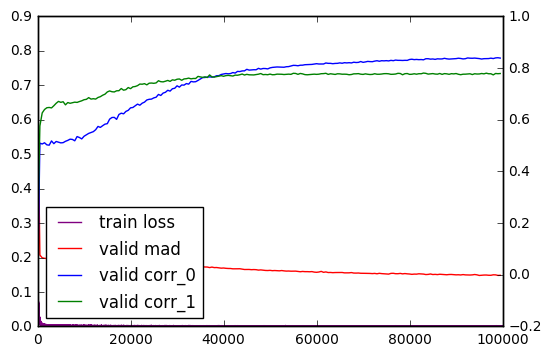

In [12]:
# Plot the training iterations vs. the training loss, the valid data mean-absolute-difference, 
# and the valid data correlation with predicted and true (y_vald) labels.
E2Nnet_sml.plot_iter_metrics() 

In [13]:
# Predict labels of test data
preds = E2Nnet_sml.predict(x_test)

In [14]:
# Compute the metrics.
E2Nnet_sml.print_results(preds, y_test)

E2E prediction results
class 0 => mae: 0.164, SDAE: 0.098, corr: 0.755, p-val: 0.000
class 1 => mae: 0.161, SDAE: 0.108, corr: 0.749, p-val: 0.000


In [15]:
# We can save the model like this.
E2Nnet_sml.save('models/E2Nnet_sml.pkl')

In [16]:
# Now let's try removing and loading the saved model.
del E2Nnet_sml
del preds

In [17]:
# Load the model like this.
E2Nnet_sml = load_model('models/E2Nnet_sml.pkl')

In [18]:
# Make sure predicts the same results using the saved/loaded model.
preds = E2Nnet_sml.predict(x_test)
# Compute the metrics.
E2Nnet_sml.print_results(preds, y_test)

E2E prediction results
class 0 => mae: 0.164, SDAE: 0.098, corr: 0.755, p-val: 0.000
class 1 => mae: 0.161, SDAE: 0.108, corr: 0.749, p-val: 0.000


In [19]:
# By default, the model parameters at the last iteration are used. 
# But we can specify an earlier iteration number and use those weights instead
# (as long as is a multiple of E2Nnet_sml.pars['snapshot'])
E2Nnet_sml.load_parameters(20000)

In [20]:
preds = E2Nnet_sml.predict(x_test)
# Compute the metrics (should be slightly worse since we are using earlier iterations)
E2Nnet_sml.print_results(preds, y_test)

E2E prediction results
class 0 => mae: 0.199, SDAE: 0.117, corr: 0.665, p-val: 0.000
class 1 => mae: 0.196, SDAE: 0.118, corr: 0.682, p-val: 0.000


<h1>Edge-to-Edge test</h1>
<p>Example of using the Edge-to-Edge (E2E) layer along with an E2N layer.</p>

In [21]:
# Unique name for the model
net_name = 'E2Enet_sml'

# Specify the architecture.
e2e_arch = [
    ['e2e', # e2e layer 
     {'n_filters': 32, # 32 feature maps 
      'kernel_h': h, 'kernel_w': w  # Sliding cross filter of size h x 1 by 1 x w
     }
    ], 
    ['e2n', {'n_filters': 64, 'kernel_h': h, 'kernel_w': w}],
    ['dropout', {'dropout_ratio': 0.5}],
    ['relu',    {'negative_slope': 0.33}],
    ['fc',      {'n_filters': 30}],
    ['relu',    {'negative_slope': 0.33}],
    ['out',     {'n_filters': n_injuries}] 
]

# Create BrainNetCNN model
E2Enet_sml = BrainNetCNN(net_name, e2e_arch, 
                         hardware='gpu', # Or 'cpu'.
                         dir_data='./generated_synthetic_data', # Where to write the data to.
                        )

In [22]:
# Overwrite default parameters.
# ann4brains.nets.get_default_hyper_params() shows the hyper-parameters that can be overwritten.
E2Enet_sml.pars['max_iter'] = 100000 # Train the model for 100K iterations.
E2Enet_sml.pars['test_interval'] = 500 # Check the valid data every 500 iterations.
E2Enet_sml.pars['snapshot'] = 10000 # Save the model weights every 10000 iterations.

# NOTE using the above parameters takes awhile for the model to train (~2 hours ish? on a GPU)
# If you want to do some simple fast experiments to start, use these settings instead.
#E2Nnet_sml.pars['max_iter'] = 1000 # Train the model for 1000 iterations.
#E2Nnet_sml.pars['test_interval'] = 50 # Check the valid data every 50 iterations.
#E2Nnet_sml.pars['snapshot'] = 1000 # Save the model weights every 1000 iterations.

In [23]:
# Train (optimize) the network.
# WARNING: this could take awhile... (like 2 hours with a GPU). Perhaps lower the max_iter
E2Enet_sml.fit(x_train, y_train, x_valid, y_valid)  # If no valid data, could put test data here.

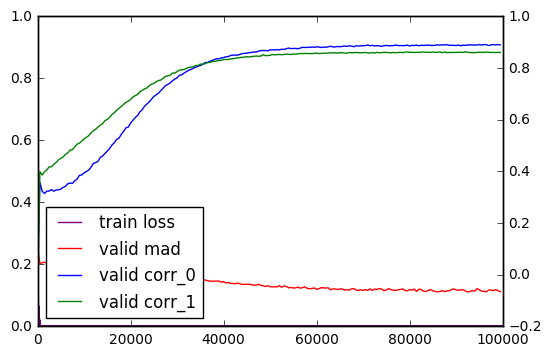

In [24]:
# Visualize the training loss, and valid metrics over training iterations.
E2Enet_sml.plot_iter_metrics() 

In [25]:
# Predict labels of test data
preds = E2Enet_sml.predict(x_test)

In [26]:
# Compute the metrics.
E2Enet_sml.print_results(preds, y_test)

E2E prediction results
class 0 => mae: 0.130, SDAE: 0.089, corr: 0.823, p-val: 0.000
class 1 => mae: 0.130, SDAE: 0.092, corr: 0.862, p-val: 0.000
